<a href="https://colab.research.google.com/github/serjisa/py-fastglmpca/blob/main/examples/Coordinates_projection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projecting coordinates of the new data using existing loadings

This approach is similar to the projecting of new data points onto existing PCA model with loadings, with only difference — new coordinates in GLM-PCA still should be learned (but this learning os usually much faster as soon as you need to update only half of the model). Also it might make processing of multiple datasets more consistent.

In [ ]:
!pip install fastglmpca scanpy

In [3]:
import scanpy as sc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import fastglmpca

sc.set_figure_params(dpi=100)
sns.set_style("ticks")

In [ ]:
adata_processed = sc.datasets.pbmc3k_processed()

adata = sc.datasets.pbmc3k()[adata_processed.obs_names].copy()
adata.obs["cell_type"] = adata_processed.obs["louvain"]
sc.pp.filter_genes(adata, min_cells=1)

Here we will learn the original embedding with 20 PCs:

In [5]:
model = fastglmpca.poisson(adata.X, n_pcs=20, return_model=True)
adata.obsm["X_glmpca"] = model.U

GLM-PCA Iterations:   8%|▊         | 75/1000 [01:24<17:26,  1.13s/it, delta=9.93e-05, loglik=1052097.0000, lr=2.50e-01]


And after that we can use this model to project the same data:

In [6]:
adata.obsm["X_glmpca_projection"] = model.project(adata.X)

Project (opt LL):   4%|▍         | 39/1000 [00:23<09:43,  1.65it/s, delta=8.94e-05, loglik=1051573.0000, lr=5.00e-01]


We can see that the training time is much smaller in the second case (23 seconds vs. 84 seconds — almost 4 times difference). We expect that the new embedding will be similar to the old one:

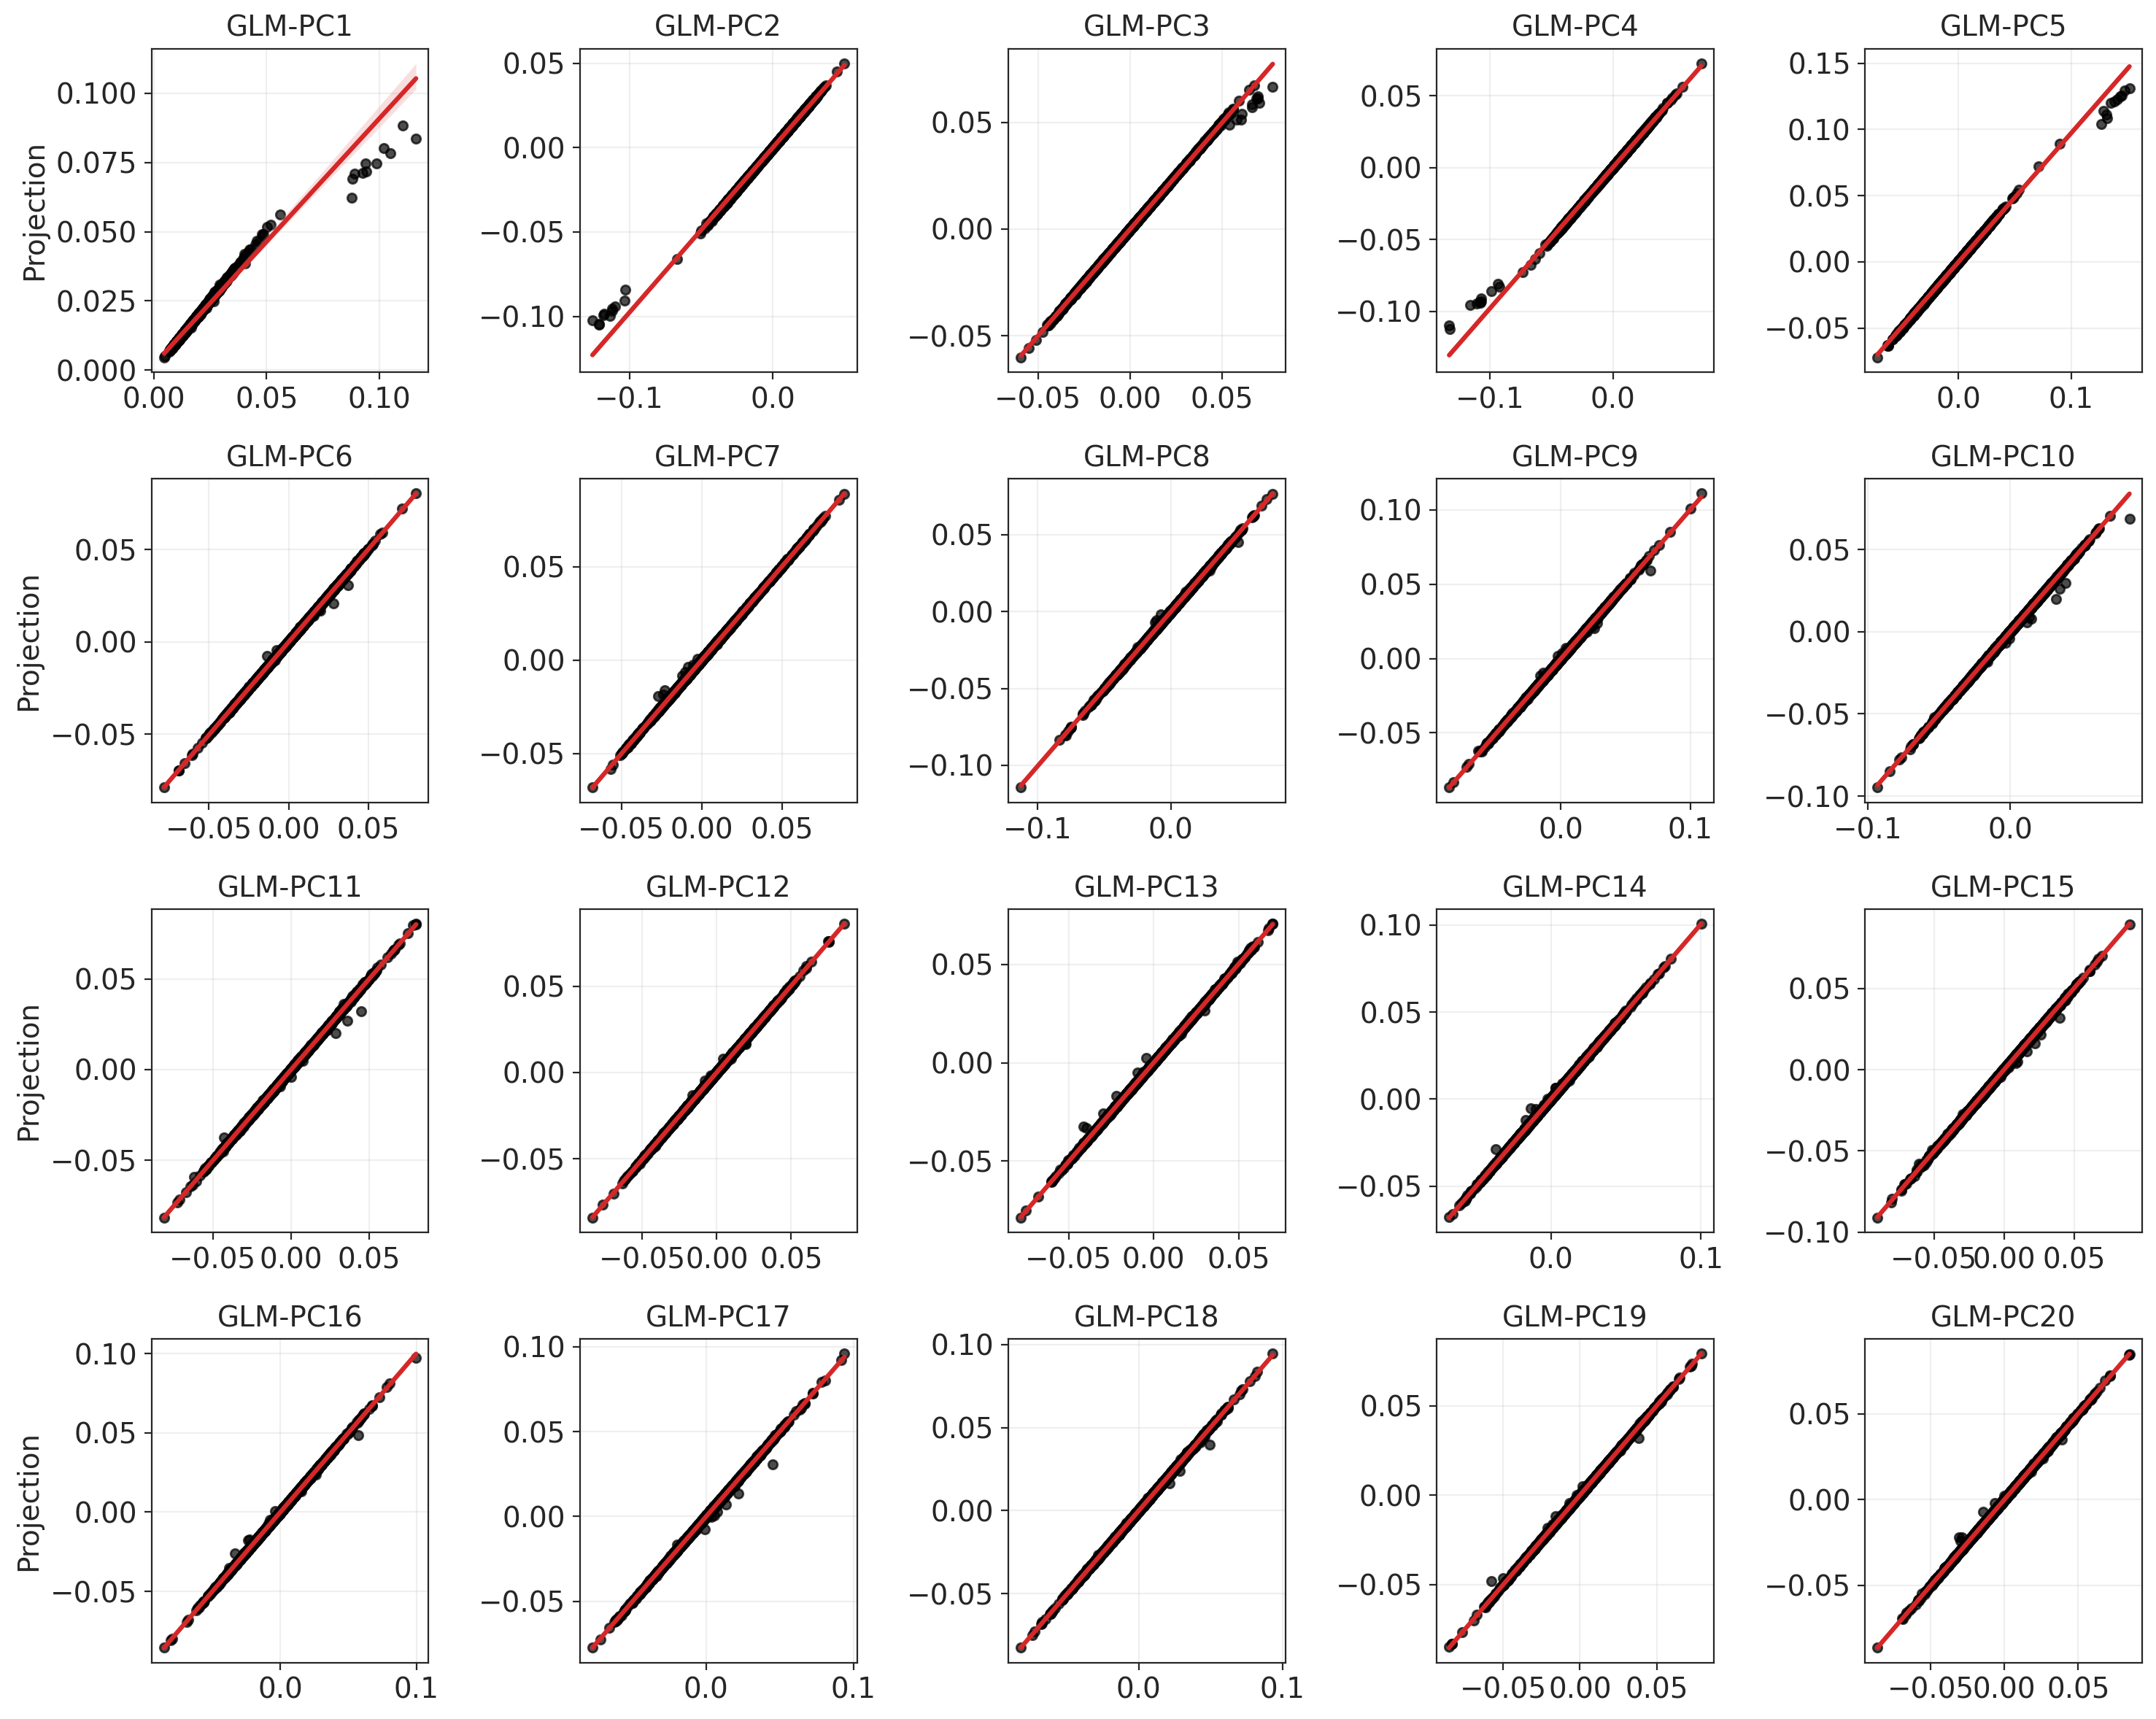

In [7]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(3 * 5, 3 * 4))

for i in range(20):
    row = i // 5
    col = i % 5
    ax = axes[row, col]

    sns.regplot(
        x=adata.obsm["X_glmpca"][:, i],
        y=adata.obsm["X_glmpca_projection"][:, i],
        ax=ax,
        scatter_kws={"alpha": 0.7, "color": "k", "s": 20},
        line_kws={"color": sns.color_palette()[3]},
    )
    if col == 0:
        ax.set_ylabel("Projection")
    else:
        ax.set_ylabel("")
    if row == 4:
        ax.set_xlabel("Original")
    else:
        ax.set_xlabel("")

    ax.grid(alpha=0.3)
    ax.set_title(f"GLM-PC{i + 1}")

plt.tight_layout()

We see that we basically got almost identical embedding. You can decrease parameter `tol` (e.g. `tol=1e-5`) during training and projection — in this case the original embedding and the projection will be even more similar.